Basic maps/analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import polars as pl
from ipywidgets import interact, IntSlider
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D  # activates 3D projection
import folium

BBOX = {
    "lat_min": 52.3383,
    "lat_max": 52.6755,
    "lon_min": 13.0884,
    "lon_max": 13.7612,
}

In [ ]:
df = pl.read_parquet("../data/2024-citsci-pollutants.parquet")

In [ ]:
df.head()

timestamp,P1,P2,lat,lon,sensor_id
str,f64,f64,f64,f64,i64
"""2024-03-28T00:00:40""",14.9,10.93,52.508,13.422,9392
"""2024-03-28T00:03:41""",16.17,12.1,52.508,13.422,9392
"""2024-03-28T00:06:43""",13.1,12.1,52.508,13.422,9392
"""2024-03-28T00:09:45""",12.8,11.63,52.508,13.422,9392
"""2024-03-28T00:12:46""",12.57,11.7,52.508,13.422,9392


In [ ]:
# Ensure timestamp is parsed as datetime
df = df.with_columns(pl.col("timestamp").str.strptime(pl.Datetime))

df = df.with_columns(
    pl.col("timestamp").dt.round("1m")
)

# Ensure all sensors are in berlin
df = df.filter(
    (pl.col("lat").is_between(BBOX["lat_min"], BBOX["lat_max"])) &
    (pl.col("lon").is_between(BBOX["lon_min"], BBOX["lon_max"]))
)


In [ ]:
df.head()

timestamp,P1,P2,lat,lon,sensor_id
datetime[μs],f64,f64,f64,f64,i64
2024-03-28 00:01:00,14.9,10.93,52.508,13.422,9392
2024-03-28 00:04:00,16.17,12.1,52.508,13.422,9392
2024-03-28 00:07:00,13.1,12.1,52.508,13.422,9392
2024-03-28 00:10:00,12.8,11.63,52.508,13.422,9392
2024-03-28 00:13:00,12.57,11.7,52.508,13.422,9392


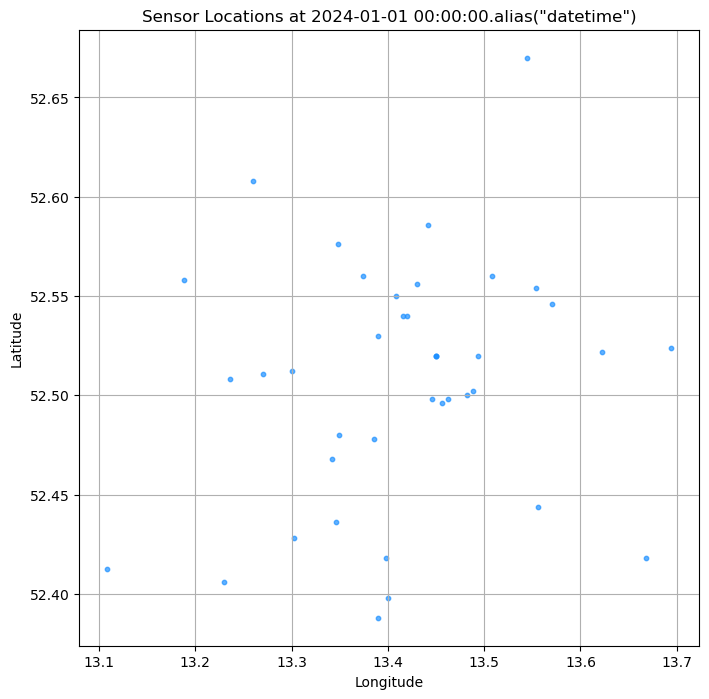

In [ ]:
# Filter to that timestamp - may need to quantize times....
ts_dt = pl.datetime(2024, 1, 1, 0, 0, 0)
ts = str(ts_dt)
snapshot = df.filter(pl.col("timestamp") == ts_dt)

plt.figure(figsize=(8, 8))
plt.scatter(snapshot["lon"], snapshot["lat"], c="dodgerblue", s=10, alpha=0.7)
plt.title(f"Sensor Locations at {ts}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [ ]:
# Get timestamps that fall exactly on the hour (minute == 0)
timestamps = (
    df.filter(pl.col("timestamp").dt.minute() == 0)
      .select("timestamp")
      .unique()
      .sort("timestamp")["timestamp"]
      .to_list()
)

xlim = (BBOX["lon_min"], BBOX["lon_max"])
ylim = (BBOX["lat_min"], BBOX["lat_max"])

def plot_snapshot(i):
    """Plot snapshot for timestamp index i"""
    ts = timestamps[i]
    snapshot = df.filter(pl.col("timestamp") == ts)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(snapshot["lon"], snapshot["lat"], c="dodgerblue", s=10, alpha=0.7)
    plt.title(f"Sensor Locations at {ts}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)

    # Fix x/y limits
    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.show()

# Interactive slider: scroll through timestamps
interact(plot_snapshot, i=IntSlider(min=0, max=len(timestamps)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='i', max=8744), Output()), _dom_classes=('widget-interact…

<function __main__.plot_snapshot(i)>

In [ ]:
# Compute center of map for initial view
center_lat = (BBOX["lat_min"] + BBOX["lat_max"]) / 2
center_lon = (BBOX["lon_min"] + BBOX["lon_max"]) / 2

# Function to create a folium map snapshot
def plot_snapshot(i):
    ts = timestamps[i]
    snapshot = df.filter(pl.col("timestamp") == ts)
    
    # Create folium map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
    
    # Add each sensor point
    for _, row in snapshot.to_pandas().iterrows():
        folium.CircleMarker(
            location=[row["lat"], row["lon"]],
            radius=4,
            color="dodgerblue",
            fill=True,
            fill_opacity=0.7
        ).add_to(m)
    
    # Add a title using a Marker (Folium does not natively support titles)
    folium.Marker(
        location=[center_lat, center_lon],
        icon=folium.DivIcon(html=f"<div style='font-size:16pt'>Sensors at {ts.strftime('%Y-%m-%d %H:%M')}</div>")
    ).add_to(m)
    
    display(m)

# Interactive slider to scroll through hourly timestamps
interact(
    plot_snapshot,
    i=IntSlider(min=0, max=len(timestamps)-1, step=1, value=0, continuous_update=False)
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=8744), Output()), _dom_…

<function __main__.plot_snapshot(i)>